# Recurrent Neural Networks: Multivariate datasets

RNNs are not the best option to work with multivariate time series, because:
- They are black box models which we cannot be investigated so easily to figure why predictions work or don't work
- There are other approaches for time series analysis and modelling which tell more clearly for what is happening (i.e., they are more interpretable); these approaches deal also with multivariate data -- among them, we have ARIMAX, SARIMAX, VARIMAX, etc.

A related course by J.M Portilla that covers timeseries models is

[Python for Financial Analysis and Algorithmic Trading](https://www.udemy.com/course/python-for-finance-and-trading-algorithms/)

My personal notes and notebooks created after coding along while following that course can be found here:

[https://github.com/mxagar/finance_accounting_courses/tree/main/python_finance](https://github.com/mxagar/finance_accounting_courses/tree/main/python_finance)

Or, for me:

`~/git_repositories/finance_accounting_courses`.

**The only changes we need to do**:
- `n_features` is not `1` anymore, but the number of variables we have
- the final `Dense` layer needs to have also `n_features` outputs

**... the rest remains identical! However, we might want to reduce the number of units, because otherwise the training takes very long...**

The used dataset consists of house temperature and humidity conditions monitored every 10 mins with ZigBee wireless sensors for 4.5 months.
The original dataset with variable descriptions can be found on

[Appliances energy prediction Data Set ](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)

**Important note**: in a multivariate timeseries all values of all features predict the values of the same features in the future; thus, we should not mix it with a multivariate regression model in which we have *independent* and *dependent* (i.e., *predicted*) variables.

## 1. Load and prepared the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../data/energydata_complete.csv',
                 index_col='date',
                 infer_datetime_format=True)

In [10]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

<AxesSubplot:xlabel='date'>

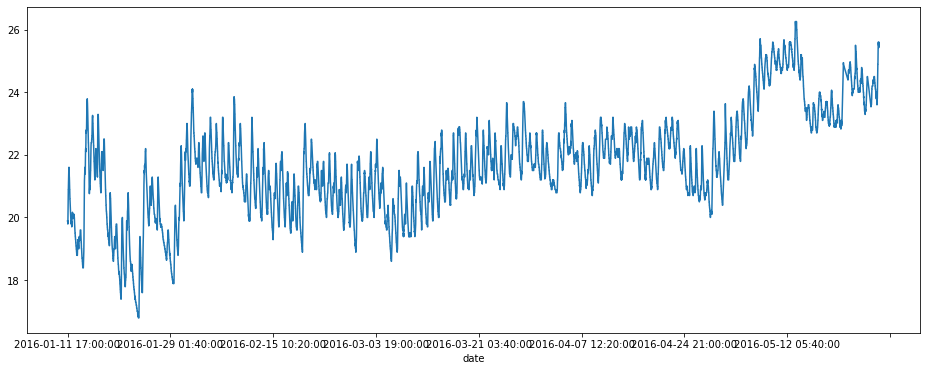

In [11]:
# We can plot some variables
# We see it's quite noisy
df['T1'].plot(figsize=(16,6))

In [13]:
# We don't need thehigh precission in the data, with so much decimal points
# We round it to make training easier
df = df.round(2)

### Train/Test Split

In [14]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.7,45.59,...,23.2,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.7,45.59,...,23.2,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.7,45.73,...,23.2,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20
2016-05-27 17:50:00,420,10,25.50,46.99,25.41,43.04,26.89,41.29,24.7,45.79,...,23.2,46.82,22.33,755.2,56.67,3.83,26.17,13.23,6.32,6.32
2016-05-27 18:00:00,430,10,25.50,46.60,25.26,42.97,26.82,41.16,24.7,45.96,...,23.2,46.84,22.20,755.2,57.00,4.00,27.00,13.20,34.12,34.12


In [17]:
# We take the last two days as the test split
test_index = int(2 * 24 * 60 / 10)

In [18]:
test_index

288

In [19]:
train = df.iloc[:-test_index]

In [20]:
test = df.iloc[-test_index:]

In [23]:
train.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 17:20:00,120,0,24.5,37.22,24.13,34.30,25.20,37.64,24.36,38.29,...,21.89,37.03,16.17,756.17,52.67,1.33,31.33,6.43,33.46,33.46
2016-05-25 17:30:00,190,0,24.5,37.16,24.10,34.30,25.20,37.55,24.29,38.16,...,21.89,37.20,16.25,756.15,53.50,1.50,33.50,6.75,0.43,0.43
2016-05-25 17:40:00,160,0,24.5,37.43,24.10,34.43,25.14,37.28,24.29,38.00,...,21.89,37.33,16.33,756.13,54.33,1.67,35.67,7.07,16.67,16.67
2016-05-25 17:50:00,90,0,24.5,37.63,24.03,34.43,25.10,36.99,24.29,37.93,...,22.00,37.36,16.42,756.12,55.17,1.83,37.83,7.38,39.36,39.36
2016-05-25 18:00:00,100,0,24.5,38.00,24.00,34.40,25.10,36.73,24.29,37.86,...,22.00,37.36,16.50,756.10,56.00,2.00,40.00,7.70,38.63,38.63


In [24]:
len(test)

288

### Scale Data

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

In [27]:
scaler.fit(train)

MinMaxScaler()

In [28]:
scaled_train = scaler.transform(train)

In [29]:
scaled_test = scaler.transform(test)

### Time Series Generator

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
# The length of the input series must be smaller than the length of the test split
# if we do early-stopping validation
# We define the batch length to be 1 day
length = int(1 * 24 * 60 / 10)
batch_size = 1

In [33]:
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [34]:
# We check the first (X,y) pair of the generator
X,y = generator[0]

In [39]:
X

array([[[0.04672897, 0.42857143, 0.32734952, ..., 0.53846154,
         0.26545309, 0.26545309],
        [0.04672897, 0.42857143, 0.32734952, ..., 0.53393665,
         0.37207441, 0.37207441],
        [0.03738318, 0.42857143, 0.32734952, ..., 0.52941176,
         0.57271454, 0.57271454],
        ...,
        [0.02803738, 0.        , 0.34952482, ..., 0.42986425,
         0.6015203 , 0.6015203 ],
        [0.02803738, 0.        , 0.34952482, ..., 0.42081448,
         0.23864773, 0.23864773],
        [0.02803738, 0.        , 0.34952482, ..., 0.41176471,
         0.25805161, 0.25805161]]])

In [40]:
X.shape

(1, 144, 28)

In [41]:
y

array([[0.04672897, 0.        , 0.34635692, 0.43505779, 0.21075581,
        0.61737419, 0.21511628, 0.74474053, 0.37477477, 0.63593683,
        0.21680993, 0.31699248, 0.35574964, 0.76734075, 0.25918944,
        0.52163121, 0.20970696, 0.55483208, 0.22996878, 0.58319536,
        0.36977492, 0.34651163, 0.67105263, 0.5       , 0.43076923,
        0.40271493, 0.72934587, 0.72934587]])

## 2. Create and Train the Model

In [37]:
from tensorflow.keras.models import Sequential

In [43]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [44]:
scaled_train.shape

(19447, 28)

In [45]:
n_features = scaled_train.shape[1]
model = Sequential()
#model.add(SimpleRNN(units=100,input_shape=(length,n_features)))
# We explicitly use the ReLu activation
# We can also vary the number of units and see what happens
model.add(LSTM(units=25,activation='relu',input_shape=(length,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam',loss='mse')

2021-12-21 17:16:21.562780: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 17:16:21.563402: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                5400      
_________________________________________________________________
dense (Dense)                (None, 28)                728       
Total params: 6,128
Trainable params: 6,128
Non-trainable params: 0
_________________________________________________________________


### Early Stopping

In [47]:
# We need to create a validation generator
# The length is the same as before,
# taking into account that it must be shorter than the length of the validation split
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Train

Training such a model takes a very long time.
Therefore, I did not train it, but I just loaded the pre-trained model provided in the course.

In [ ]:
# We train with an early stop callback
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

In [ ]:
# We get the loss values and plot them
losses = pd.DataFrame(model.history.history)

In [ ]:
losses.plot()

### Load Pre-Trained Model

In [52]:
from tensorflow.keras.models import load_model

In [56]:
later_model = load_model('multivariate.h5')

## 3. Forecasting / Inference

In [54]:
# We forecast one by one all the values in the test split
# For that, the batch previous to the test split is taken
# a prediction done for it. and then,
# the batch is moved in the time to contain predicted values
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [59]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[-1.50338029e+02,  5.85519075e+00,  2.33786774e+01, ...,
         1.39771539e+00,  2.83515933e+01,  3.50054487e+01],
       [-1.14335547e+02,  8.12065899e+00,  2.40961213e+01, ...,
         3.51618921e+00,  2.75948461e+01,  3.54038797e+01],
       [-1.00469955e+02,  9.15695712e+00,  2.43347270e+01, ...,
         3.86802480e+00,  2.78469472e+01,  3.49977195e+01],
       ...,
       [ 1.27270666e+25,  3.27535704e+24,  5.26961731e+23, ...,
        -1.20049281e+24,  5.72293211e+24, -6.60928265e+23],
       [ 1.55279578e+25,  3.99617563e+24,  6.42931853e+23, ...,
        -1.46468923e+24,  6.98239733e+24, -8.06380918e+23],
       [ 1.89452500e+25,  4.87562808e+24,  7.84424127e+23, ...,
        -1.78702842e+24,  8.51903699e+24, -9.83843989e+23]])

In [60]:
predictions = pd.DataFrame(true_predictions,columns=df.columns)

In [61]:
predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,-1.503380e+02,5.855191e+00,2.337868e+01,4.434810e+01,2.205181e+01,3.489718e+01,2.369804e+01,3.959744e+01,2.285566e+01,3.816558e+01,...,2.204839e+01,3.862051e+01,8.226962e+00,7.626281e+02,8.453718e+01,3.044858e+00,3.137099e+01,1.397715e+00,2.835159e+01,3.500545e+01
1,-1.143355e+02,8.120659e+00,2.409612e+01,4.536600e+01,2.231839e+01,3.358194e+01,2.422616e+01,4.051356e+01,2.350520e+01,3.826857e+01,...,2.178683e+01,4.015690e+01,9.092518e+00,7.641933e+02,8.703928e+01,3.318394e+00,3.540922e+01,3.516189e+00,2.759485e+01,3.540388e+01
2,-1.004700e+02,9.156957e+00,2.433473e+01,4.573159e+01,2.192757e+01,3.357292e+01,2.455461e+01,4.088836e+01,2.390517e+01,3.812719e+01,...,2.171393e+01,4.068303e+01,9.419157e+00,7.649089e+02,8.893714e+01,3.588230e+00,3.639634e+01,3.868025e+00,2.784695e+01,3.499772e+01
3,-8.980404e+01,9.508060e+00,2.450637e+01,4.603707e+01,2.169926e+01,3.383430e+01,2.483763e+01,4.132441e+01,2.419753e+01,3.824405e+01,...,2.172621e+01,4.123180e+01,9.862192e+00,7.658497e+02,9.087123e+01,3.901989e+00,3.709127e+01,4.059714e+00,2.855697e+01,3.518685e+01
4,-8.464123e+01,9.852653e+00,2.468701e+01,4.643926e+01,2.156007e+01,3.431228e+01,2.509065e+01,4.175618e+01,2.445184e+01,3.844407e+01,...,2.181084e+01,4.175222e+01,1.032146e+01,7.668485e+02,9.294324e+01,4.194467e+00,3.777545e+01,4.122018e+00,2.943511e+01,3.556940e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,8.549808e+24,2.200325e+24,3.540032e+23,2.018511e+24,-6.520993e+23,3.692447e+24,8.596889e+23,1.018897e+24,9.431686e+23,-7.532218e+22,...,4.150263e+23,1.503963e+24,1.303610e+24,3.698895e+24,5.510912e+24,7.551523e+23,2.960722e+24,-8.064690e+23,3.844560e+24,-4.439995e+23
284,1.043139e+25,2.684558e+24,4.319099e+23,2.462731e+24,-7.956090e+23,4.505056e+24,1.048883e+24,1.243129e+24,1.150735e+24,-9.189859e+22,...,5.063625e+23,1.834945e+24,1.590500e+24,4.512923e+24,6.723717e+24,9.213413e+23,3.612298e+24,-9.839513e+23,4.690646e+24,-5.417119e+23
285,1.272707e+25,3.275357e+24,5.269617e+23,3.004712e+24,-9.707013e+23,5.496499e+24,1.279715e+24,1.516709e+24,1.403981e+24,-1.121231e+23,...,6.177994e+23,2.238768e+24,1.940527e+24,5.506097e+24,8.203428e+24,1.124104e+24,4.407268e+24,-1.200493e+24,5.722932e+24,-6.609283e+23
286,1.552796e+25,3.996176e+24,6.429319e+23,3.665970e+24,-1.184327e+24,6.706132e+24,1.561346e+24,1.850496e+24,1.712960e+24,-1.367984e+23,...,7.537605e+23,2.731461e+24,2.367585e+24,6.717842e+24,1.000878e+25,1.371489e+24,5.377191e+24,-1.464689e+24,6.982397e+24,-8.063809e+23
